# 4. Constituent Level Prediction (Churn Analysis)

Here, we perform analysis at the constituent level for the years 2016/2017. We include RFM (Recency, Frequency and Monetary Value) variables into the analysis and generate new variables from our existing dataset. 

**Objective:** predict constituent churn for 2017 

**Approach:** use several classification/regression models 


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns 
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import os
os.chdir('M:\\PH-RPM\\Elba\\Data\\')
data= pd.read_csv('MANIFOLD_MERGED_CLEANED.csv')

#Importing Foundation data for 2016-2017 
foundation = pd.read_excel('PBI_Data_8-10-2018.xlsx')
foundation = foundation.rename(columns={'ConcatPC': 'Postal_Code'})
foundation = foundation.drop(['First Name','Last Name'], axis =1)

#Importing Manifold data for 2017
data.to_csv('MANIFOLD_BC_ALL.csv')

In [3]:
foundation.head(5)

,CID (AG),Organization Name,Constituency Description,Average household income $,Postal_Code,Recency(5),Frequency(10),2016,2017,2017churn,Primary RM
0,1122472,NaN,Individual,679097,V7V3G1,4,2,1000.0,NaN,churn,NaN
1,1071560,NaN,Individual,678844,V7V3G2,4,3,50.0,NaN,churn,NaN
2,619413,NaN,Individual,678844,V7V3G2,4,2,5000.0,NaN,churn,NaN
3,432990,NaN,Individual,678703,V7V3H3,5,3,100.0,379.0,renew,NaN
4,1137335,NaN,Individual,678699,V7V2K8,3,1,250.0,NaN,churn,NaN


In [4]:
#Merge our Manifold Data with our foundation's donation data for 2016-17
data = pd.merge(foundation, data, on='Postal_Code')

## Cleaning + Feature Engineering
***

Let's convert the variables *'Primary RM', 'Organization Name', 'Constituency Description'* and *'2017Churn'* to dummies that we can include in our models. These variables are defined as follows:
* `Primary RM`: Individual assigned to the constituent given the latter's strong donation potential 

* `Organization Name`: For individuals who indicate organization, the name of the organization 

* `Constituency Description`: Whether the constituent is an individual or an organization 

* `2017Churn`: Whether an individual that donated in 2016 donated in 2017 or not (churn vs renew) 


In [5]:
#Converting NaN's to zero 
data['Primary RM'] = data['Primary RM'].fillna(0)
data['Primary RM'].tail(10)

#Converting names to 1 in primary RM variable 
def to_number_RM(row):
    if row!= 0:
        return 'RM' 
    elif row == 0:
        return 'No_RM'
    
#Applying function
data['Primary RM'] = data['Primary RM'].apply(to_number_RM)

#Converting names to 1 in Organization Name variable 
def to_number_Org(row):
    if row!= 0:
        return 'Organization' 
    elif row == 0:
        return 'Constituent'

#Organization Name
data['Organization Name'] = data['Organization Name'].fillna(0)
data['Constituent_Type'] = data['Organization Name'].apply(to_number_Org)

#Now we want to convert these variables to dummies for analysis
Org = pd.get_dummies(data['Constituent_Type'])
P_RM = pd.get_dummies(data['Primary RM'])
Churn = pd.get_dummies(data['2017churn'])

#Finally, we merge these to our main dataset 
data = pd.concat([data, Org], axis=1)
data = pd.concat([data, P_RM], axis=1)
data = pd.concat([data, Churn], axis=1)

#Remember that when creating dummy variables we remove one of them to avoid the 'dummy variable trap'
data = data.drop(['Organization Name','Constituency Description','2017' ,'Constituent_Type', 'No_RM', 'renew', 'Organization',\
                 '2017churn', 'Primary RM', 'Unnamed: 0'], axis=1)

In [6]:
data.head(5)

,CID (AG),Average household income $,Postal_Code,Recency(5),Frequency(10),2016,Population_Total,Pop_15_plus,Dwellings_Tot,ChildCount,...,Tot_Priv_HH_Age_35-44,Tot_Priv_HH_Age_45-54,Tot_Priv_HH_Age_55-64,Tot_Priv_HH_Age_65-74,Tot_Priv_HH_Age_25-34,Tot_Priv_HH_Age_u_25,Tot_Priv_HH_Age_75_o,Constituent,RM,churn
0,1122472,679097,V7V3G1,4,2,1000.0,36,30,12,6,...,2,5,4,1,0,0,0,1,0,1
1,1071560,678844,V7V3G2,4,3,50.0,16,14,5,2,...,1,2,2,1,0,0,0,1,0,1
2,619413,678844,V7V3G2,4,2,5000.0,16,14,5,2,...,1,2,2,1,0,0,0,1,0,1
3,432990,678703,V7V3H3,5,3,100.0,35,29,12,6,...,2,5,3,1,0,0,0,1,0,0
4,1137335,678699,V7V2K8,3,1,250.0,55,46,18,9,...,2,8,5,2,0,0,0,1,0,1


Other variables that we have imported and generating are the following: 


In [7]:
# A bit more cleaning 
#First, we want to convert the nulls (postal codes that didn't donate in 2016/2017) to zeros
data['2016'].isnull().sum()
data['2016'] = data['2016'].fillna(0)

In [8]:
data['ChildPopRatio'] = (( data['Population_Total'] - data['Pop_15_plus'])/data['Population_Total'])

In [9]:
Household_Income = ['HH_Inc_1','HH_Inc_2','HH_Inc_3','HH_Inc_4', 'HH_Inc_5','HH_Inc_6','HH_Inc_7','HH_Inc_8',\
                   'HH_Inc_9','HH_Inc_10','HH_Inc_11','HH_Inc_12','HH_Inc_13']
d = data['Dwellings_Tot'] 

for x in Household_Income: 
    data[x] = data[x]/d

In [10]:
data['HH_Inc_Low'] =  data['HH_Inc_1'] + data['HH_Inc_2'] + data['HH_Inc_3'] + data['HH_Inc_4'] \
+ data['HH_Inc_5']  + data['HH_Inc_6'] 
data['HH_Inc_Med'] =  data['HH_Inc_7'] + data['HH_Inc_8'] + data['HH_Inc_9'] + data['HH_Inc_10'] 
data['HH_Inc_High'] = data['HH_Inc_11'] + data['HH_Inc_12'] + data['HH_Inc_13']

In [11]:
#Household ownership 
data['Owned_Dwelling_Percent'] = data['Owned-Count-PC']/data['Dwellings_Tot']
data['Rented_Dwelling_Percent'] = data['Rented-Count-PC']/data['Dwellings_Tot']
data['Band_Dwelling_Percent'] = data['Band housing-Count-PC_y']/data['Dwellings_Tot']
#Age of owners
data['Older_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_55-64'] + data['Tot_Priv_HH_Age_65-74'] + \
                                   data['Tot_Priv_HH_Age_75_o'])/data['Dwellings_Tot']
data['Younger_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_25-34'] + data['Tot_Priv_HH_Age_35-44'] + \
                                     data['Tot_Priv_HH_Age_u_25'] + data['Tot_Priv_HH_Age_45-54']  )/data['Dwellings_Tot']
data['Most_Senior_Owner_Percent'] = data['Tot_Priv_HH_Age_75_o']/data['Dwellings_Tot']

## EDA
***

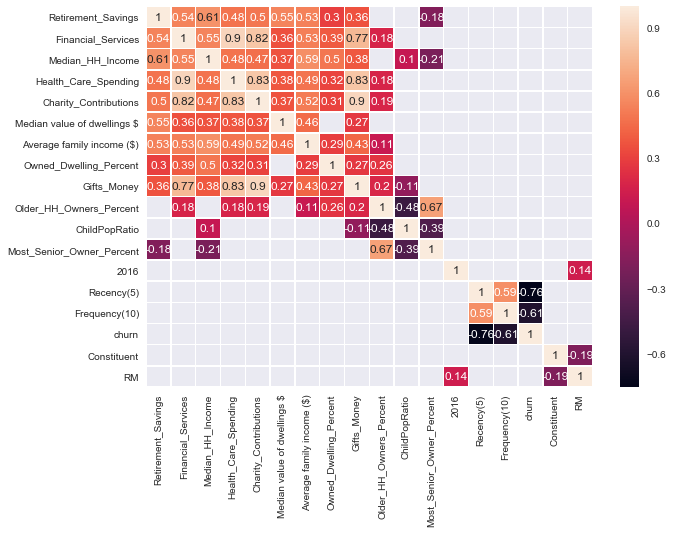

In [12]:
#Looking at correlation between variables
data_1 =data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent', '2016',\
             'Recency(5)','Frequency(10)', 'churn', 'Constituent', 'RM']] 

corr = data_1.corr()
sns.set(font_scale = 1.0)
mask = np.absolute(corr) > 0.10
fig, ax = plt.subplots(figsize=(10,7)) # Sample figsize in inches

sns.heatmap(corr[mask], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,  linewidths=.5,ax=ax)
plt.show()

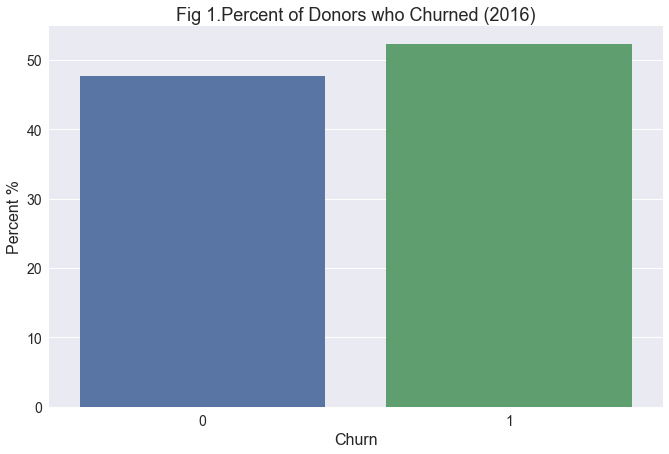

In [13]:
#Plot donor churn 
plt.figure(figsize=(11,7))
sns.set(style="whitegrid")
sns.set(font_scale = 1.4)
ax = sns.barplot(x='churn', y='churn' , data=data, estimator=lambda churn: len(churn) / len(data) * 100)
ax.set_xlabel(xlabel='Churn', fontsize=16)
ax.set_ylabel(ylabel='Percent %', fontsize=16)
ax.set_title(label='Fig 1.Percent of Donors who Churned (2016)', fontsize=18)
plt.show();

* Here we can observe that 53% of donors that donated in 2016 didn't donate in 2017 while 47% of individuals that donated in 2016 continued to donate the following year.

<Figure size 432x288 with 0 Axes>

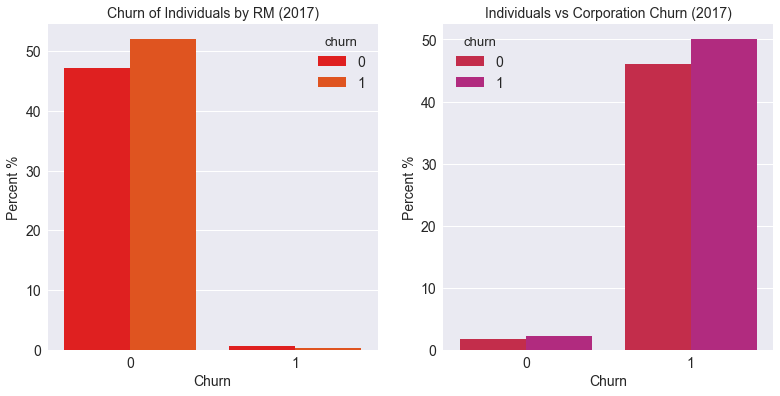

In [14]:
#Now we want to take a look at the variables we just created: 'churn', 'Constituent', 'RM'
#Plot donor churn 
plt.figure(figsize=(6,4))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.set(style="whitegrid")
sns.set(font_scale = 1.4)

fig1 = sns.barplot(x='RM', y='RM' , data=data, estimator=lambda RM: len(RM) / len(data) * 100, hue='churn',\
               palette = ['r', 'orangered'], ax=ax1)

fig1.set_xlabel(xlabel='Churn', fontsize=14)
fig1.set_ylabel(ylabel='Percent %', fontsize=14)
fig1.set_title(label='Churn of Individuals by RM (2017)', fontsize=14)

fig2 = sns.barplot(x='Constituent', y='Constituent' , data=data, estimator=lambda Constituent: len(Constituent) / len(data) * 100, hue='churn',\
                palette=['crimson', 'mediumvioletred'], ax=ax2)
fig2.set_xlabel(xlabel='Churn', fontsize=14)
fig2.set_ylabel(ylabel='Percent %', fontsize=14)
fig2.set_title(label='Individuals vs Corporation Churn (2017)', fontsize=14)
plt.show();

* Looking at our new features, we observe that for individuals with or without RM the probability of churning is mostly in tandem with the overall 53-47% probabilities. Interestingly, for individuals who do have an RM, more of them tend to renew rather than churn. In terms fo individuals vs. corporations, we see almost the same trend as overall for either alternative. 

* Thus, these new features don't bring too much variation in terms of discerning who churns vs who doesn't. Yet, for now, since we don't have too many variables, we keep this additional information. 

<Figure size 432x288 with 0 Axes>

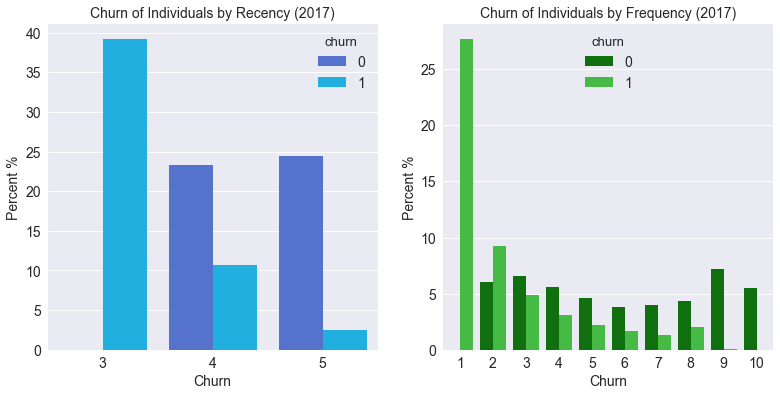

In [15]:
#Now we want to take a look at the variables we just created: 'churn', 'Constituent', 'RM'
#https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
data = data.rename(columns={'Recency(5)': 'Recency_5', 'Frequency(10)': 'Frequency_10'})

#Plot donor churn 
plt.figure(figsize=(6,4))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.set(style="whitegrid")
sns.set(font_scale = 1.4)

fig1 = sns.barplot(x='Recency_5', y='Recency_5' , data=data, estimator=lambda Recency_5: len(Recency_5) / len(data) * 100, hue='churn',\
                palette=['royalblue', 'deepskyblue'], ax=ax1)


fig1.set_xlabel(xlabel='Churn', fontsize=14)
fig1.set_ylabel(ylabel='Percent %', fontsize=14)
fig1.set_title(label='Churn of Individuals by Recency (2017)', fontsize=14)


fig2 = sns.barplot(x='Frequency_10', y='Frequency_10' , data=data, estimator=lambda Frequency_10: len(Frequency_10) / len(data) * 100, hue='churn',\
                palette=['green', 'limegreen'], ax=ax2)
fig2.set_xlabel(xlabel='Churn', fontsize=14)
fig2.set_ylabel(ylabel='Percent %', fontsize=14)
fig2.set_title(label='Churn of Individuals by Frequency (2017)', fontsize=14)
plt.show();

First, let's define the RFM variables: 
* `Recency`: How recently a customer has purchased; in our case how recently a constituent has donated where our scale goes from 1: last time they donated was 5 years ago to 5: they donated last year. 
* `Frequency`: How often they donate: 10 means they have donated 10 times in the past 10 years whereas 1 means that they have donated once in the past 10 years 
* `Monetary Value`: How much the customer spends. This would be our 2016 variable

Observations:note that individuals that donated in 2016 have made previous donations as old as three years ago max but not further (eg. no one that doanted in 2016 donated last in 2012). In terms of frequency, constituents that have donated more than two times in the past 10 years have a higher retention to churn rates. 

## Prediction
***
* Boosting
* Random Forest 

In [16]:
rng = np.random.RandomState(1)
rng

In [17]:
#Remove last year 
def Remove_last_year_1(row):
    if row == 10:
        return '9' 
    if row == 9: 
        return '9'
    if row == 8:
        return '8'
    if row ==7:
        return '7'
    if row ==6:
        return '6'
    if row ==5:
        return '5'
    if row ==4:
        return '4'
    if row ==3:
        return '3'
    if row ==2:
        return '2'
    if row ==1:
        return '1'
def Remove_last_year_2(row):
    if row == 5:
        return '4' 
    if row ==4:
        return '4'
    if row ==3:
        return '3'
    if row ==2:
        return '2'
    if row ==1:
        return '1'   
data['Recency(4)'] = data['Recency_5'].apply(Remove_last_year_2)
data['Frequency(9)'] = data['Frequency_10'].apply(Remove_last_year_1)

## `Boosting`

In [25]:
# Import modules 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1, criterion='entropy')

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180 , random_state=1)

#Separate features and outcome
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
            'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.95


## `Random Forest`

In [26]:
# PREPROCESSING
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

#Separate features and outcome
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
            'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_estimators=500, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(X_train, y_train)

y_pred_proba = rf.predict(X_test)

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(roc_auc))

ROC AUC score: 0.93


### Now, we want to visualize feature importance 

In [28]:
rf.feature_importances_

array([0.01715485, 0.01549354, 0.01637991, 0.01585401, 0.01537236,
       0.01752734, 0.01618166, 0.01448775, 0.01588726, 0.01479724,
       0.01567663, 0.01045248, 0.00132417, 0.00065406, 0.4685059 ,
       0.25780538, 0.08644547])

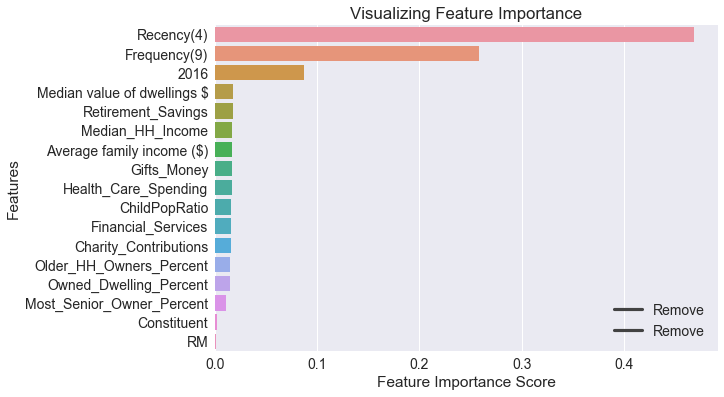

In [29]:
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_, index =['Retirement_Savings' ,'Financial_Services', 'Median_HH_Income', \
                                                         "Health_Care_Spending","Charity_Contributions",'Median value of dwellings $', \
                                                         'Average family income ($)', 'Owned_Dwelling_Percent','Gifts_Money', \
                                                         'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
                                                         'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016'] ).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Creating a bar plot
plt.figure(figsize=(9,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
plt.legend(['Remove','Remove'])
plt.show()

As we expected, our new variables- namely 'Constituent' and 'RM' are not very important in terms of predicting rentention rates for a particular year. Therefore, we will now eliminate them and re-run our model. Additionally, note that most of our other variables have around the same importance level. We also know that these variables are correlated amongst each other. Let's run a PCA on these variables in order to get a better picture of our data. 

In [22]:
# PREPROCESSING
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

#Separate features and outcome
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
              'Recency(4)','Frequency(9)']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_estimators=500, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(X_train, y_train)

y_pred_proba = rf.predict(X_test)

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(roc_auc))

ROC AUC score: 0.92


Let's take a look at the ROC's of our three models

https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html